# Using models with top-down feedback 

This notebook demonstrates training and testing a sample network with top-down feedback on the MNIST dataset.

## 1. Import Required Libraries for Training

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import csv

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda
CUDA available: True


## 2. Load and Preprocess MNIST Dataset

Download the MNIST dataset using torchvision, apply necessary transformations, and create DataLoader objects for training and testing.

Training samples: 60000
Test samples: 10000
Batch size: 64
Sample image shape: torch.Size([1, 28, 28])
Sample label: 5


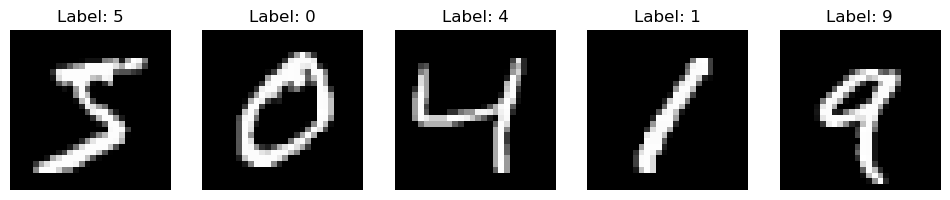

In [2]:
# Define transforms for preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

# Display a sample image
sample_data, sample_label = train_dataset[0]
print(f"Sample image shape: {sample_data.shape}")
print(f"Sample label: {sample_label}")

# Visualize sample images
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    image, label = train_dataset[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

## 3. Load the connectivity graph
The Graph details the connectivity between all model regions as well as parameters like the size of hidden state

In [7]:
from connectome_to_model.model.graph import Graph
from connectome_to_model.model.architectures import ConnectomicsConvGRU

input_node = [0]                                  # Nodes which receive inputs, can be multiple
output_node = [2]                                    # Readout nodes, list or int, can be multiple                               

# Load graph. For this example, we use a simple 3 layer network with feedback connections
graph_loc = 'graphs/sample_graph.csv'
graph = Graph(graph_loc, input_nodes=input_node, output_nodes=output_node)

# Sizes of stimuli. They can be fetched from the graph if they're not different from the input size/dims of the input nodes
# If different from the input size/dims of the input nodes, the model will do a convolutional projection before feeding into model. Recommended for big inputs
input_sizes = graph.find_input_sizes()  
input_dims = graph.find_input_dims()

## 4. Build the Network Based on the Graph

In [8]:
model = ConnectomicsConvGRU(graph, input_sizes, input_dims,
                    topdown=True).cuda().float()

print(f"Graph created with {graph.num_node} nodes")
print(f"Input nodes: {graph.input_indices}")
print(f"Output nodes: {graph.output_indices}")

# Print node information
for i, node in enumerate(graph.nodes):
    print(f"Node {i}: input_size={node.input_size}, input_dim={node.input_dim}, hidden_dim={node.hidden_dim}")

Graph created with 3 nodes
Input nodes: [0]
Output nodes: [2]
Node 0: input_size=(28, 28), input_dim=1, hidden_dim=32
Node 1: input_size=(14, 14), input_dim=10, hidden_dim=32
Node 2: input_size=(7, 7), input_dim=10, hidden_dim=32


For a classification task, train a task-based readout as well that converts neural representations from the output area to a label.

In [16]:
from connectome_to_model.model.readouts import ClassifierReadout

readout = ClassifierReadout(
    output_size=model.output_sizes[0], # Grab the output size from the model
    n_classes=10,  # MNIST has 10 classes
).cuda().float()

In [18]:
print(model.output_sizes)

[(7, 7, 32)]


## 5. Train the Network on MNIST

Starting training...
Device: cuda
Graph dtype: <class 'torch.cuda.FloatTensor'>


Epoch 1/5: 100%|██████████| 938/938 [00:19<00:00, 48.54it/s, Loss=0.2673, Acc=91.23%]


Epoch 1/5:
  Training Loss: 0.2601
  Training Accuracy: 91.47%
  Learning Rate: 0.001000


Epoch 2/5: 100%|██████████| 938/938 [00:19<00:00, 48.28it/s, Loss=0.0803, Acc=97.44%]


Epoch 2/5:
  Training Loss: 0.0797
  Training Accuracy: 97.46%
  Learning Rate: 0.001000


Epoch 3/5: 100%|██████████| 938/938 [00:18<00:00, 51.22it/s, Loss=0.0688, Acc=97.85%]


Epoch 3/5:
  Training Loss: 0.0691
  Training Accuracy: 97.85%
  Learning Rate: 0.001000


Epoch 4/5: 100%|██████████| 938/938 [00:18<00:00, 50.33it/s, Loss=0.0604, Acc=98.01%]


Epoch 4/5:
  Training Loss: 0.0611
  Training Accuracy: 97.99%
  Learning Rate: 0.001000


Epoch 5/5: 100%|██████████| 938/938 [00:18<00:00, 50.60it/s, Loss=0.0573, Acc=98.21%]


Epoch 5/5:
  Training Loss: 0.0576
  Training Accuracy: 98.21%
  Learning Rate: 0.001000
Training completed!


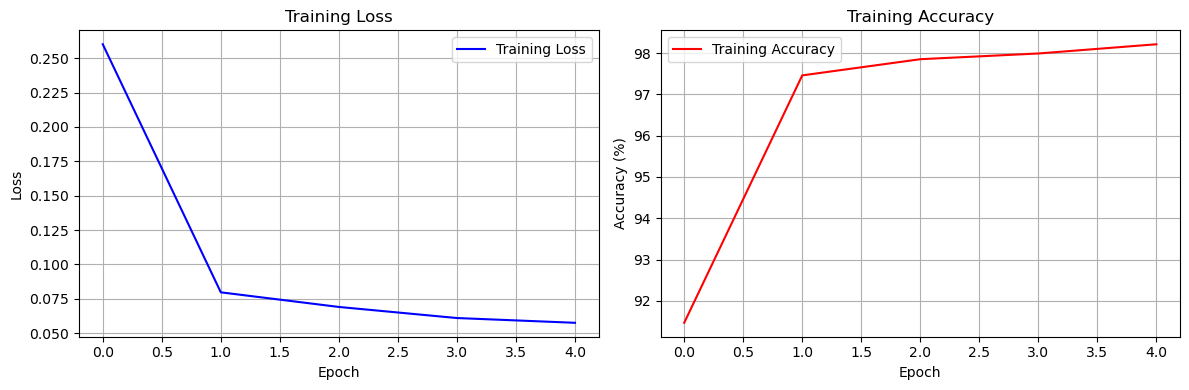

In [21]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model.parameters()) + list(readout.parameters()), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training parameters
num_epochs = 5
train_losses = []
train_accuracies = []

print("Starting training...")
print(f"Device: {device}")
print(f"Graph dtype: {model.graph.dtype}")

for epoch in range(num_epochs):
    model.train()
    readout.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training loop with progress bar
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, (data, target) in enumerate(train_pbar):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        if data.dim() == 4:  # (batch, channel, height, width)
            data = data.unsqueeze(1)  # (batch, 1, channel, height, width)
        input_list = [data]
        features = model(input_list).flatten(start_dim=1)
        output = readout(features)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        if batch_idx % 100 == 0:
            accuracy = 100. * correct / total
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{accuracy:.2f}%'
            })
    
    # End of epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Training Loss: {epoch_loss:.4f}')
    print(f'  Training Accuracy: {epoch_accuracy:.2f}%')
    print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Step the scheduler
    scheduler.step()

print("Training completed!")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, 'b-', label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, 'r-', label='Training Accuracy')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 7. Evaluate the Network on Test Data

Run the trained model on the test DataLoader and compute accuracy and loss metrics.

Evaluating on test set...
Using graph dtype: <class 'torch.cuda.FloatTensor'>


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.76it/s, Acc=98.79%]



Test Results:
  Test Loss: 0.0350
  Test Accuracy: 98.79% (9879/10000)

Per-class accuracy:
  Class 0: 99.08% (971/980)
  Class 1: 99.47% (1129/1135)
  Class 2: 100.00% (1032/1032)
  Class 3: 99.01% (1000/1010)
  Class 4: 97.96% (962/982)
  Class 5: 98.21% (876/892)
  Class 6: 99.06% (949/958)
  Class 7: 98.44% (1012/1028)
  Class 8: 98.05% (955/974)
  Class 9: 98.41% (993/1009)


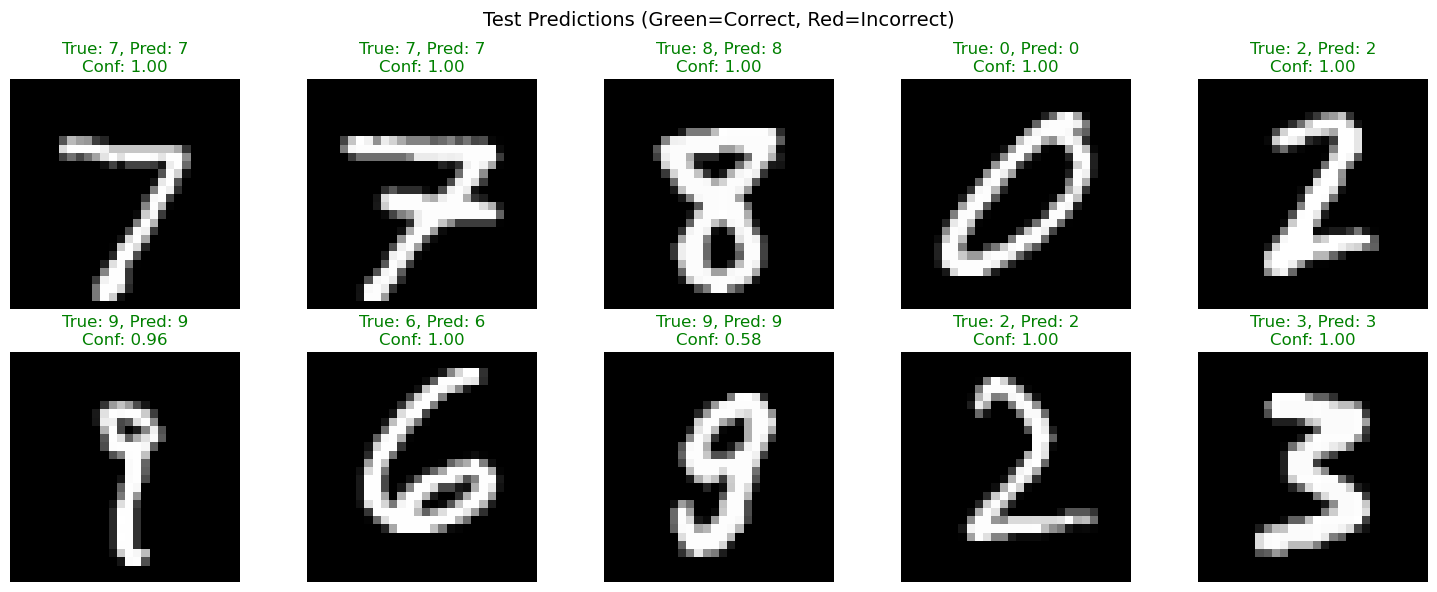

In [24]:
# Evaluation on test set
model.eval()
test_loss = 0
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

print("Evaluating on test set...")
print(f"Using graph dtype: {model.graph.dtype}")

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc='Testing')
    for data, target in test_pbar:
        data, target = data.to(device), target.to(device)
        
        # Format input properly: add time dimension and wrap in list for model
        if data.dim() == 4:  # (batch, channel, height, width)
            data = data.unsqueeze(1)  # (batch, 1, channel, height, width)
            
        # Model expects a list of tensors, one for each input node
        input_list = [data]  # Wrap in list since we have one input node
        
        output = model(input_list)
        output = readout(output.flatten(start_dim=1))
        test_loss += criterion(output, target).item()
        
        # Get predictions
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Per-class accuracy
        c = (predicted == target).squeeze()
        for i in range(target.size(0)):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
        # Update progress bar
        test_pbar.set_postfix({
            'Acc': f'{100. * correct / total:.2f}%'
        })

# Calculate final metrics
test_loss /= len(test_loader)
test_accuracy = 100. * correct / total

print(f'\nTest Results:')
print(f'  Test Loss: {test_loss:.4f}')
print(f'  Test Accuracy: {test_accuracy:.2f}% ({correct}/{total})')

# Per-class accuracy
print('\nPer-class accuracy:')
for i in range(10):
    if class_total[i] > 0:
        class_acc = 100. * class_correct[i] / class_total[i]
        print(f'  Class {i}: {class_acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')

# Visualize some test predictions
def visualize_predictions(model, test_loader, num_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break
            data, target = data.to(device), target.to(device)
            
            # Format input properly: add time dimension and wrap in list for model
            if data.dim() == 4:  # (batch, channel, height, width)
                data = data.unsqueeze(1)  # (batch, 1, channel, height, width)
                
            # Model expects a list of tensors, one for each input node
            input_list = [data]  # Wrap in list since we have one input node
            
            output = model(input_list).flatten(start_dim=1)
            output = readout(output)
            _, predicted = torch.max(output, 1)
            
            # Get first image from batch
            img = data[0].cpu().squeeze()
            true_label = target[0].cpu().item()
            pred_label = predicted[0].cpu().item()
            confidence = torch.softmax(output[0], dim=0)[pred_label].cpu().item()
            
            axes[i].imshow(img, cmap='gray')
            color = 'green' if true_label == pred_label else 'red'
            axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}', 
                             color=color)
            axes[i].axis('off')
    
    plt.suptitle('Test Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)